# Student Lifestyle Project — EDA, Modeling, and Mediation
This notebook uses **all available columns** and treats **`grades`** as the academic outcome target.
If your file has a different name for grades (e.g., *GPA*, *grade*, *final_score*), the loader below will **rename it to `grades`** automatically.


In [2]:

# --- 1) Setup & Load Data ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import statsmodels.api as sm

plt.rcParams['figure.dpi'] = 120  # crisper plots

CSV_PATH = r"./data/student_lifestyle_dataset.csv"

df = pd.read_csv(CSV_PATH)

def canonical_rename(cols):
    m = {}
    for c in cols:
        lc = c.lower().strip()
        # Map any GPA/grade-like field to 'grades'
        if ('gpa' in lc and 'gap' not in lc) or ('grade' in lc) or ('score' in lc and 'stress' not in lc):
            m[c] = 'grades'
        elif 'sleep' in lc:
            m[c] = 'sleep'
        elif 'study' in lc or 'hours_stud' in lc:
            m[c] = 'study'
        elif 'exerc' in lc or 'workout' in lc or 'fitness' in lc:
            m[c] = 'exercise'
        elif 'social' in lc or 'friends' in lc or 'interaction' in lc:
            m[c] = 'social'
        elif 'stress' in lc or 'anxiety' in lc or 'pressure' in lc:
            m[c] = 'stress'
        else:
            m[c] = c
    return m

df = df.rename(columns=canonical_rename(df.columns))
print("Shape:", df.shape)
df.head(10)


Shape: (2000, 9)


,Student_ID,study,Extracurricular_Hours_Per_Day,sleep,social,Physical_Activity_Hours_Per_Day,stress,Gender,grades
0,1,6.9,3.8,8.7,2.8,1.8,Moderate,Male,7.48
1,2,5.3,3.5,8.0,4.2,3.0,Low,Female,6.88
2,3,5.1,3.9,9.2,1.2,4.6,Low,Male,6.68
3,4,6.5,2.1,7.2,1.7,6.5,Moderate,Male,7.20
4,5,8.1,0.6,6.5,2.2,6.6,High,Male,8.78
5,6,6.0,2.1,8.0,0.3,7.6,Moderate,Female,7.12
6,7,8.0,0.7,5.3,5.7,4.3,High,Male,7.70
7,8,8.4,1.8,5.6,3.0,5.2,High,Male,8.00
8,9,5.2,3.6,6.3,4.0,4.9,Low,Male,7.05
9,10,7.7,0.7,9.8,4.5,1.3,Moderate,Female,6.90


,Student_ID,study,Extracurricular_Hours_Per_Day,sleep,social,Physical_Activity_Hours_Per_Day,stress,Gender,grades
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000,2000,2000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,3,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,High,Male,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1029,1016,NaN
mean,1000.500000,7.475800,1.990100,7.501250,2.704550,4.32830,NaN,NaN,7.789825
std,577.494589,1.423888,1.155855,1.460949,1.688514,2.51411,NaN,NaN,0.746777
min,1.000000,5.000000,0.000000,5.000000,0.000000,0.00000,NaN,NaN,5.600000
25%,500.750000,6.300000,1.000000,6.200000,1.200000,2.40000,NaN,NaN,7.250000
50%,1000.500000,7.400000,2.000000,7.500000,2.600000,4.10000,NaN,NaN,7.780000
75%,1500.250000,8.700000,3.000000,8.800000,4.100000,6.10000,NaN,NaN,8.320000


Missing fraction by column:
 Student_ID                         0.0
study                              0.0
Extracurricular_Hours_Per_Day      0.0
sleep                              0.0
social                             0.0
Physical_Activity_Hours_Per_Day    0.0
stress                             0.0
Gender                             0.0
grades                             0.0
dtype: float64


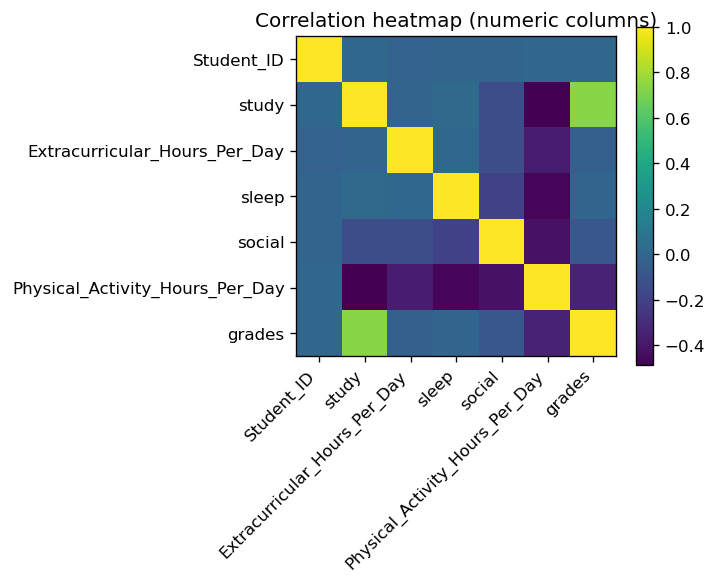

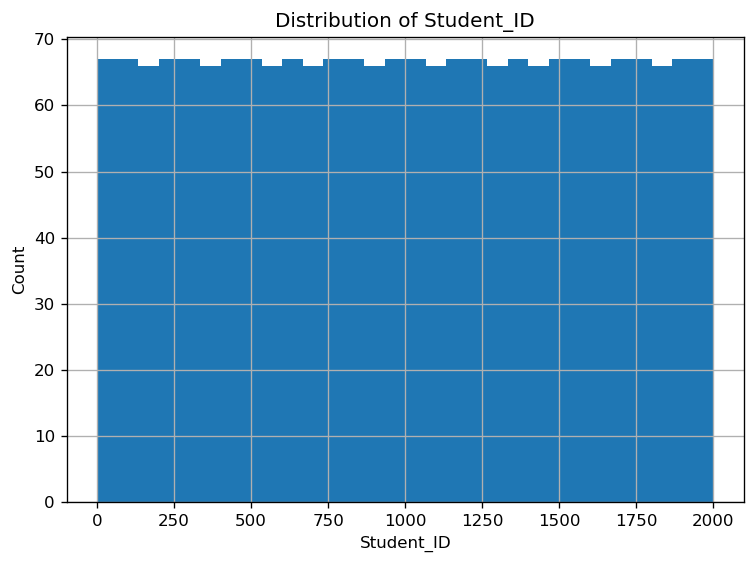

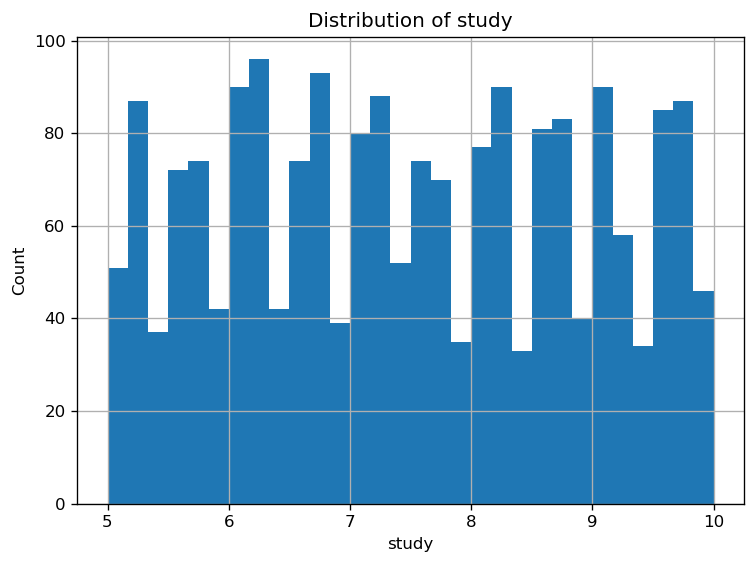

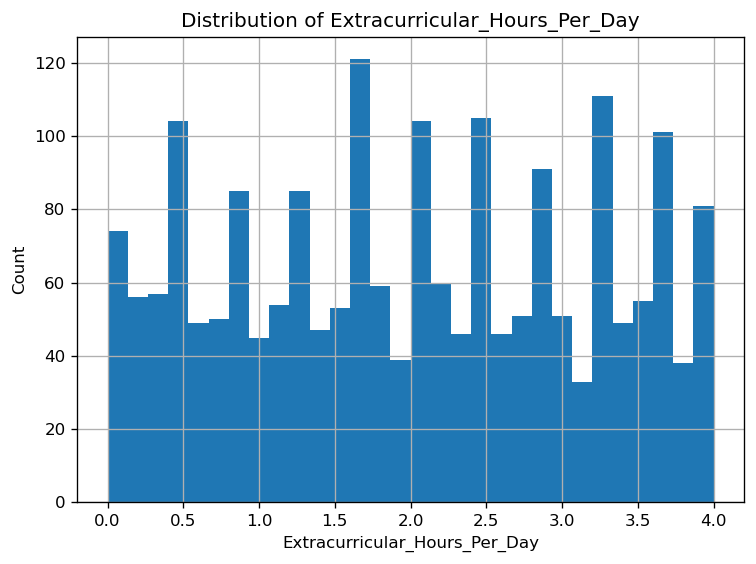

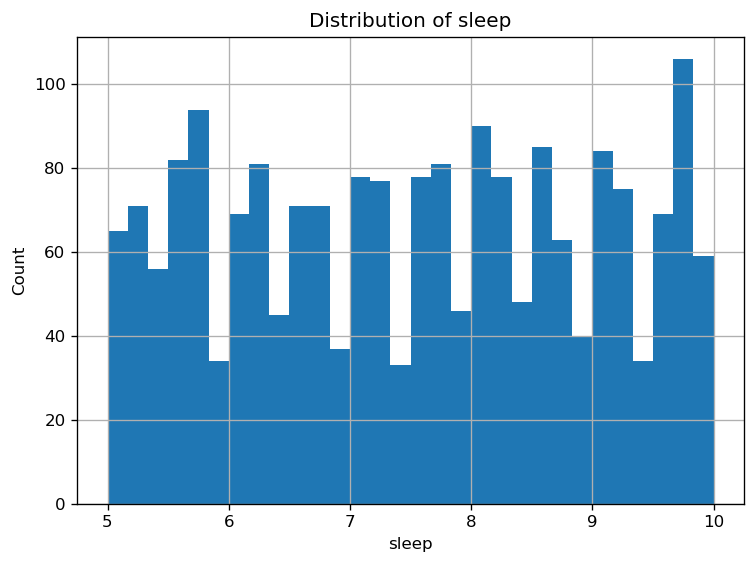

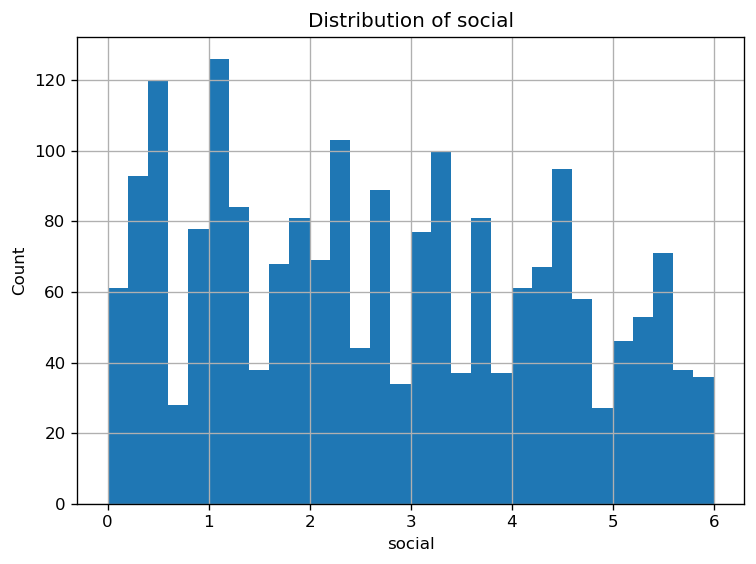

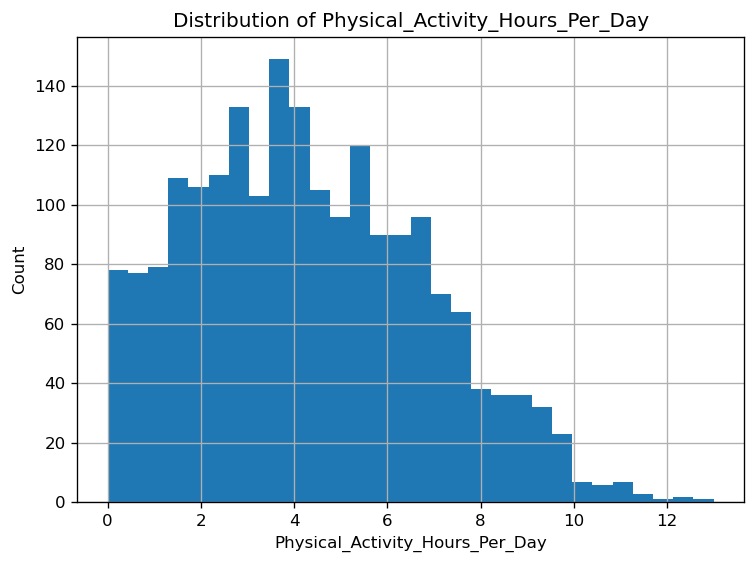

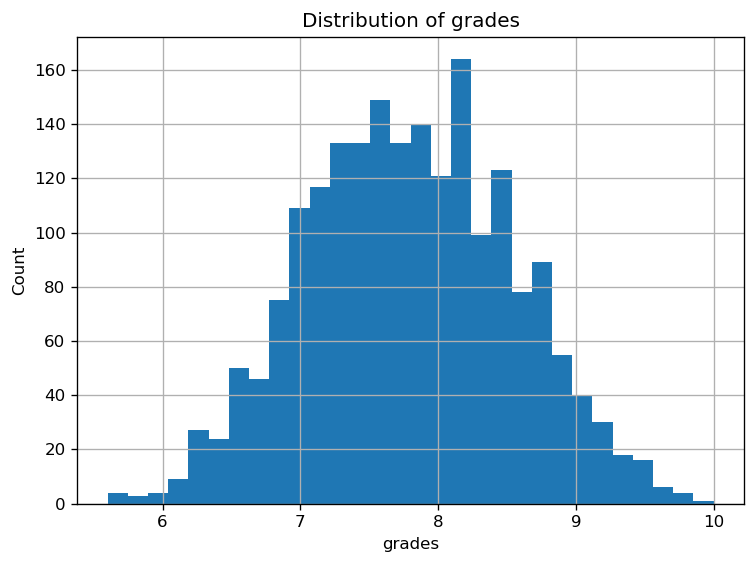

In [3]:

# --- 2) Quick EDA ---
display(df.describe(include='all'))

missing = df.isna().mean().sort_values(ascending=False)
print("Missing fraction by column:\n", missing)

# Numeric correlation heatmap (uses all numeric columns; safe if none)
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols_all) >= 2:
    corr = df[num_cols_all].corr()
    plt.figure(figsize=(6,5))
    plt.imshow(corr, interpolation='nearest')
    plt.xticks(range(len(num_cols_all)), num_cols_all, rotation=45, ha='right')
    plt.yticks(range(len(num_cols_all)), num_cols_all)
    plt.title("Correlation heatmap (numeric columns)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Histograms for all numeric columns
for col in num_cols_all:
    plt.figure()
    df[col].dropna().hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## Grades Prediction (Regression) — Uses **all columns except `grades`**

In [4]:

# --- 3) Regression to predict 'grades' (if present) ---
if 'grades' in df.columns:
    # Features = all columns except target
    X = df.drop(columns=['grades'])
    y = df['grades']

    # Identify numeric vs categorical features
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    # Ensure y is numeric; if not, try to coerce
    if not np.issubdtype(y.dropna().infer_objects().dtype, np.number):
        y = pd.to_numeric(y, errors='coerce')

    # Preprocess
    preproc = ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('enc', OrdinalEncoder())]), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Baseline: Linear Regression
    lr = Pipeline([('prep', preproc), ('lr', LinearRegression())])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_rmse = -cross_val_score(lr, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
    cv_r2   =  cross_val_score(lr, X_train, y_train, cv=cv, scoring='r2')

    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)

    print("Linear Regression  CV RMSE:", cv_rmse.mean(), "+/-", cv_rmse.std())
    print("Linear Regression  CV R2  :", cv_r2.mean(),   "+/-", cv_r2.std())
    print("Linear Regression Test RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))
    print("Linear Regression Test R2  :", r2_score(y_test, y_pred_lr))

    # Nonlinear: Random Forest
    rf = Pipeline([('prep', preproc), ('rf', RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))])
    cv_rmse_rf = -cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
    cv_r2_rf   =  cross_val_score(rf, X_train, y_train, cv=cv, scoring='r2')

    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    print("\nRandom Forest     CV RMSE:", cv_rmse_rf.mean(), "+/-", cv_rmse_rf.std())
    print("Random Forest     CV R2  :",  cv_r2_rf.mean(),    "+/-", cv_r2_rf.std())
    print("Random Forest   Test RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
    print("Random Forest   Test R2  :", r2_score(y_test, y_pred_rf))

    # Simple feature importances for RF (best-effort; shows transformed order loosely)
    try:
        rf_model = rf.named_steps['rf']
        importances = rf_model.feature_importances_
        # OrdinalEncoder does not expand categorical features -> 1:1 mapping
        col_order = num_cols + cat_cols
        for i, col in enumerate(col_order[:len(importances)]):
            print(f"  RF importance — {col:>20s}: {importances[i]:.6f}")
    except Exception as e:
        print("Feature importance display skipped:", e)
else:
    print("No 'grades' column found after renaming. If your target is named differently, rename it to 'grades'.")


Linear Regression  CV RMSE: 0.5076031730810641 +/- 0.011510562264994018
Linear Regression  CV R2  : 0.5312213596621858 +/- 0.007997551063469612
Linear Regression Test RMSE: 0.5148593026733638
Linear Regression Test R2  : 0.5459901004315677


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Random Forest     CV RMSE: 0.5273124387479762 +/- 0.010061362759002553
Random Forest     CV R2  : 0.4938569239220437 +/- 0.01585005181183812
Random Forest   Test RMSE: 0.559696110987639
Random Forest   Test R2  : 0.4634715289975241
  RF importance —           Student_ID: 0.099018
  RF importance —                study: 0.583759
  RF importance — Extracurricular_Hours_Per_Day: 0.075115
  RF importance —                sleep: 0.071730
  RF importance —               social: 0.077592
  RF importance — Physical_Activity_Hours_Per_Day: 0.076450
  RF importance —               stress: 0.004133
  RF importance —               Gender: 0.012202


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:

# --- 4) Optional polynomial terms for 'sleep' and 'study' ---
if 'grades' in df.columns:
    X = df.drop(columns=['grades'])
    y = pd.to_numeric(df['grades'], errors='coerce')

    use_poly = [c for c in ['sleep','study'] if c in X.columns]
    if use_poly:
        poly_ct = ColumnTransformer([
            ('poly', Pipeline([('imp', SimpleImputer(strategy='median')),
                               ('poly', PolynomialFeatures(2, include_bias=False)),
                               ('sc', StandardScaler())]), use_poly),
            ('rest-num', Pipeline([('imp', SimpleImputer(strategy='median')),
                                   ('sc', StandardScaler())]), [c for c in X.select_dtypes(include=[np.number]).columns if c not in use_poly]),
            ('rest-cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                                   ('enc', OrdinalEncoder())]), [c for c in X.columns if c not in X.select_dtypes(include=[np.number]).columns and c not in use_poly])
        ], remainder='drop')

        poly_lr = Pipeline([('ct', poly_ct), ('lr', LinearRegression())])
        poly_lr.fit(X, y)
        print("Polynomial LR (sleep, study) — R2 on full data:", r2_score(y, poly_lr.predict(X)))
    else:
        print("No 'sleep'/'study' columns found; skipping polynomial demo.")


Polynomial LR (sleep, study) — R2 on full data: 0.5424729411406607


## Stress Classification (Optional) — Uses **all columns except `stress`**

LogReg CV acc: 0.8175000000000001
LogReg test acc: 0.84
LogReg test F1 (macro): 0.8419911725403916
RF CV acc: 1.0
RF test acc: 1.0
RF test F1 (macro): 1.0


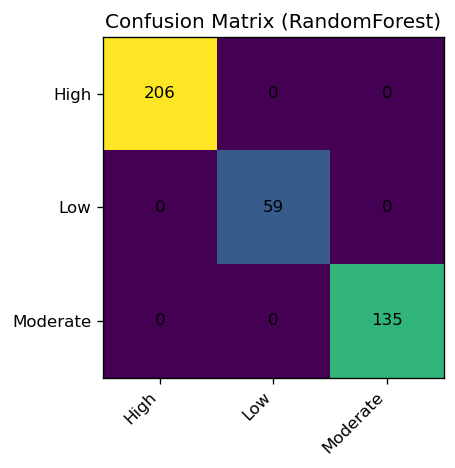

In [6]:

# --- 5) Classify stress using all other columns ---
if 'stress' in df.columns:
    Xs = df.drop(columns=['stress'])
    ys = df['stress'].astype(str)

    num_cols_s = Xs.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols_s = [c for c in Xs.columns if c not in num_cols_s]

    preproc_s = ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_cols_s),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('enc', OrdinalEncoder())]), cat_cols_s)
    ])

    Xtr, Xte, ytr, yte = train_test_split(Xs, ys, test_size=0.2, random_state=42, stratify=ys)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Logistic Regression
    logit = Pipeline([('prep', preproc_s), ('clf', LogisticRegression(max_iter=200))])
    print("LogReg CV acc:", cross_val_score(logit, Xtr, ytr, cv=cv, scoring='accuracy').mean())
    logit.fit(Xtr, ytr)
    print("LogReg test acc:", accuracy_score(yte, logit.predict(Xte)))
    print("LogReg test F1 (macro):", f1_score(yte, logit.predict(Xte), average='macro'))

    # Random Forest
    rfc = Pipeline([('prep', preproc_s), ('clf', RandomForestClassifier(n_estimators=400, random_state=42))])
    print("RF CV acc:", cross_val_score(rfc, Xtr, ytr, cv=cv, scoring='accuracy').mean())
    rfc.fit(Xtr, ytr)
    print("RF test acc:", accuracy_score(yte, rfc.predict(Xte)))
    print("RF test F1 (macro):", f1_score(yte, rfc.predict(Xte), average='macro'))

    # Confusion matrix for better of the two
    yhat_log = logit.predict(Xte)
    yhat_rf  = rfc.predict(Xte)
    better = 'rf' if accuracy_score(yte, yhat_rf) >= accuracy_score(yte, yhat_log) else 'logit'
    yhat = yhat_rf if better=='rf' else yhat_log
    labels = sorted(ys.unique().tolist())

    cm = confusion_matrix(yte, yhat, labels=labels)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix ({'RandomForest' if better=='rf' else 'LogisticRegression'})")
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.yticks(range(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.tight_layout()
    plt.show()
else:
    print("No 'stress' column found; skipping stress classification.")


## Mediation: Does Stress Mediate Study → Grades?

In [8]:
# --- 6) Mediation (study -> stress -> grades)  [ROBUST VERSION] ---
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder

need = {"study", "stress", "grades"}
if need.issubset(df.columns):
    controls = [c for c in ["sleep","exercise","social"] if c in df.columns]
    med = df[["study","stress","grades"] + controls].copy()

    # 1) Ensure numeric types (coerce where needed)
    # Grades: force numeric if it's stored as text
    if not np.issubdtype(med["grades"].dropna().infer_objects().dtype, np.number):
        med["grades"] = pd.to_numeric(med["grades"], errors="coerce")

    # Study: if text (e.g., "3-4 hrs"), try to extract numbers; else ordinal-encode
    if med["study"].dtype == object:
        # try simple numeric extraction; fallback to ordinal encoding if no digits found
        extracted = med["study"].str.extract(r"([0-9]+(?:\\.[0-9]+)?)")[0].astype(float)
        if extracted.notna().mean() > 0.5:
            med["study"] = extracted
        else:
            enc = OrdinalEncoder()
            med["study"] = enc.fit_transform(med[["study"]]).ravel()

    # Stress: map common ordinals; fallback to ordinal encoding
    stress_map = {
        "very low": 0, "low": 0,
        "moderate": 1, "medium": 1, "mid": 1,
        "high": 2,
        "very high": 3, "extreme": 3
    }
    if med["stress"].dtype == object:
        s_norm = med["stress"].astype(str).str.strip().str.lower()
        mapped = s_norm.map(stress_map)
        if mapped.notna().mean() > 0.7:           # if mapping covered most rows
            med["stress_num"] = mapped.fillna(1)  # default to middle if unknown
        else:
            enc = OrdinalEncoder()
            med["stress_num"] = enc.fit_transform(s_norm.to_frame()).ravel()
    else:
        med["stress_num"] = med["stress"].astype(float)

    # Controls: if any are non-numeric, ordinal-encode them
    for c in controls:
        if not np.issubdtype(med[c].dropna().infer_objects().dtype, np.number):
            enc = OrdinalEncoder()
            med[c] = enc.fit_transform(med[[c]]).ravel()

    # Drop rows with missing key values
    med = med.dropna(subset=["study", "stress_num", "grades"])

    # 2) Standardize ONLY numeric columns
    num_cols = med.select_dtypes(include=[np.number]).columns
    med[num_cols] = (med[num_cols] - med[num_cols].mean()) / (med[num_cols].std() + 1e-9)

    # 3) Fit mediation paths: a: stress ~ study + controls;  b,c': grades ~ study + stress + controls
    Xa = sm.add_constant(med[["study"] + controls])
    ma = sm.OLS(med["stress_num"], Xa).fit()

    Xb = sm.add_constant(med[["study", "stress_num"] + controls])
    mb = sm.OLS(med["grades"], Xb).fit()

    a, sa = ma.params["study"], ma.bse["study"]
    b, sb = mb.params["stress_num"], mb.bse["stress_num"]
    ab = a * b
    sobel_z = ab / np.sqrt((b*b*sa*sa) + (a*a*sb*sb) + 1e-12)

    print("Indirect effect (a*b):", ab)
    print("Sobel z:", sobel_z)
    print("R2: M~X:", ma.rsquared, "  Y~X+M:", mb.rsquared)
else:
    print("Need columns: 'study', 'stress', 'grades' to run mediation.")


Indirect effect (a*b): 0.0005206125940722349
Sobel z: 0.027299373124582842
R2: M~X: 0.6476944762917827   Y~X+M: 0.5400429644091596
